In [2]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.proteoscopemodule import ProteoscopeLightningModule
import numpy as np
from omegaconf import OmegaConf


# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-07-30/03-53-30" # 1 - 25x25
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-02/04-49-03" # 2 - 4x4
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
    )
    pdm.setup()

    plm2 = ProteoscopeLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        unet_number=1,
    )

    plm2.imagen.eval()
    plm2.imagen.cuda()
    plm2.cytoself_model.cuda()

/tmp/ipykernel_6321/2088810126.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/2023-08-03/04-49-03/checkpoints/last.ckpt


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:37                                                                                   │
│                                                                                                  │
│   34 │   │   unet_number=1,                                                                      │
│   35 │   )                                                                                       │
│   36 │                                                                                           │
│ ❱ 37 │   plm2.imagen.eval()                                                                      │
│   38 │   plm2.imagen.cuda()                                                                      │
│   39 │   plm2.cytoself_model.cuda()                                                              │
│   40                                                                                             │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1265 in           │
│ __getattr__                                                                                      │
│                                                                                                  │
│   1262 │   │   │   modules = self.__dict__['_modules']                                           │
│   1263 │   │   │   if name in modules:                                                           │
│   1264 │   │   │   │   return modules[name]                                                      │
│ ❱ 1265 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1266 │   │   │   type(self).__name__, name))                                                   │
│   1267 │                                                                                         │
│   1268 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'ProteoscopeLightningModule' object has no attribute 'imagen'

In [3]:
pdm.val_images_dataset.labels = pdm.val_images_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.val_dataloader(novel_proteins=False, shuffle=True)

In [3]:
# pdm.train_dataset.labels = pdm.train_dataset.labels.drop_duplicates(subset='ensg')
# dl = pdm.train_dataloader()

In [4]:
# dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)

In [5]:
plm.cond_images

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plm.cond_images                                                                              │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'plm' is not defined

In [53]:
# locs = np.concatenate(locs, axis=0)
# outputs = np.concatenate(outputs, axis=0)
# inputs = np.concatenate(inputs, axis=0)

In [6]:
import torch

In [4]:
from tqdm import tqdm

true_images = []
true_localizations = []
predicted_images = []
predicted_latents = []
true_latents = []

# batch = next(iter(dl))
# cond_images_base = batch['image'][0, 1, :, :].unsqueeze(dim=0).unsqueeze(dim=0).cuda()

for batch in tqdm(dl):
    output = plm.sample(batch, cond_scale=3, cond_images=None)
    output2 = plm2.sample(batch, cond_scale=3, cond_images=None)

    plm.cytoself_model.mse_loss = {}
    input_image = batch['image'].cuda()
    true_latent = plm.cytoself_model(input_image, plm.cytoself_layer).float()
    true_latent2 = plm2.cytoself_model(input_image, plm2.cytoself_layer).float()
    # output_image = plm.cytoself_model._connect_decoders([output, output2])
    # output2 = torch.randn_like(output2)
    # true_latent = torch.randn_like(true_latent)
    output_image = plm.cytoself_model._connect_decoders([output, output2])
    

    true_images.append(input_image.detach().cpu().numpy())
    true_localizations.append(np.array(batch['localization']))
    true_latents.append(true_latent2.detach().cpu().numpy())
    predicted_latents.append(output2.detach().cpu().numpy())
    predicted_images.append(output_image.detach().cpu().numpy())

predicted_latents = np.concatenate(predicted_latents, axis=0)
true_images = np.concatenate(true_images, axis=0)
true_localizations = np.concatenate(true_localizations, axis=0)
predicted_images = np.concatenate(predicted_images, axis=0)
true_latents = np.concatenate(true_latents, axis=0)

  0%|          | 0/17 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

  6%|▌         | 1/17 [01:21<21:46, 81.64s/it]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

  6%|▌         | 1/17 [01:23<22:13, 83.32s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:13                                                                                   │
│                                                                                                  │
│   10 # cond_images_base = batch['image'][0, 1, :, :].unsqueeze(dim=0).unsqueeze(dim=0).cuda()    │
│   11                                                                                             │
│   12 for batch in tqdm(dl):                                                                      │
│ ❱ 13 │   output = plm.sample(batch, cond_scale=3, cond_images=None)                              │
│   14 │   output2 = plm2.sample(batch, cond_scale=3, cond_images=None)                            │
│   15 │                                                                                           │
│   16 │   plm.cytoself_model.mse_loss = {}                                                        │
│                                                                                                  │
│ /home/ec2-user/proteoscope/proteoscope/proteoscopemodule.py:89 in sample                         │
│                                                                                                  │
│    86 │   │   if cond_images is not None:                                                        │
│    87 │   │   │   cond_images.to(self.imagen.device)                                             │
│    88 │   │                                                                                      │
│ ❱  89 │   │   return self.imagen.sample(text_embeds=seq_embeds, text_masks=seq_mask, cond_imag   │
│    90 │   │   # return self.imagen.sample(text_embeds=None, text_masks=None, cond_images=None,   │
│    91 │                                                                                          │
│    92 │   def configure_optimizers(self):                                                        │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/autograd/grad_mode.py:27 in            │
│ decorate_context                                                                                 │
│                                                                                                  │
│    24 │   │   @functools.wraps(func)                                                             │
│    25 │   │   def decorate_context(*args, **kwargs):                                             │
│    26 │   │   │   with self.clone():                                                             │
│ ❱  27 │   │   │   │   return func(*args, **kwargs)                                               │
│    28 │   │   return cast(F, decorate_context)                                                   │
│    29 │                                                                                          │
│    30 │   def _wrap_generator(self, func):                                                       │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/imagen_pytorch/imagen_pytorch.py:110 in      │
│ inner                                                                                            │
│                                                                                                  │
│    107 │   def inner(model, *args, **kwargs):                                                    │
│    108 │   │   was_training = model.training                                                     │
│    109 │   │   model.eval()                                                                      │
│ ❱  110 │   │   out = fn(model, *args, **kwargs)                                                  │
│    111 │   │   model.train(was_training)                   

In [5]:
predicted_latents = np.concatenate(predicted_latents, axis=0)
true_images = np.concatenate(true_images, axis=0)
true_localizations = np.concatenate(true_localizations, axis=0)
predicted_images = np.concatenate(predicted_images, axis=0)
true_latents = np.concatenate(true_latents, axis=0)

In [6]:
print(predicted_images.shape)
print(predicted_latents.shape)

(64, 2, 100, 100)
(64, 64, 4, 4)


In [7]:
import matplotlib.pyplot as plt

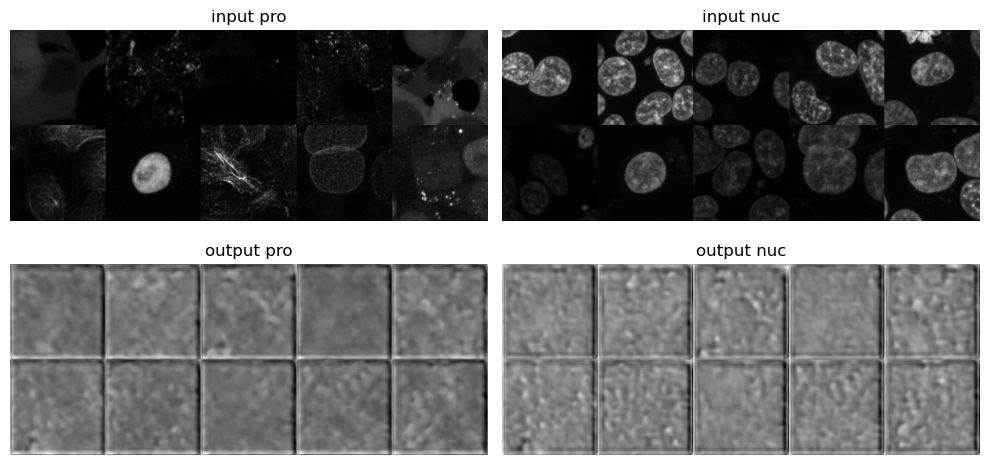

In [8]:
data_ch = ['pro', 'nuc']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(true_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(predicted_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [9]:
# def merge_images(img_A, img_B):
#     rgb = np.tile(img_A, (3, 1, 1)).transpose(1, 2, 0)
#     rgb[:, :, 1] = img_B
#     return rgb

In [10]:
# plt.imshow(merge_images(output_images[id], input_images[id]))

# Cytoself

In [11]:
import zarr
import numpy as np
from os.path import join

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "good_embeddings.zarr")

embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
localizations = np.load(join(datapath, "good_localizations.npy"))

In [12]:
from joblib import load

reducer = load(join(datapath,'good_umap_model.joblib'))

In [13]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))
localizations[localizations == ''] = 'other'

In [14]:
import seaborn as sns

label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

<AxesSubplot:>

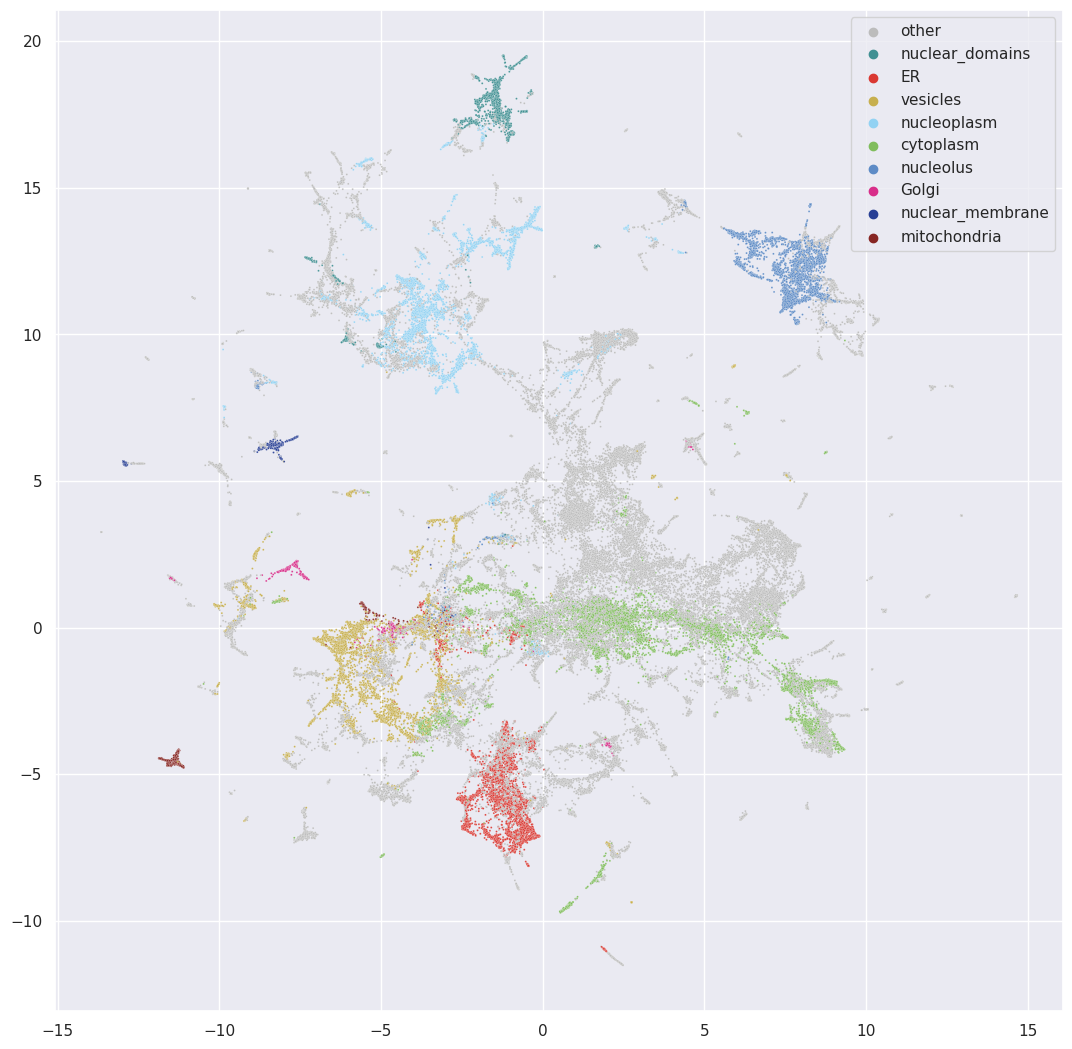

In [15]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)

In [16]:
reduced_outputs = reducer.transform(predicted_latents.reshape(predicted_latents.shape[0], -1))
reduced_locs = true_localizations
reduced_locs[reduced_locs == ''] = 'other'

<AxesSubplot:>

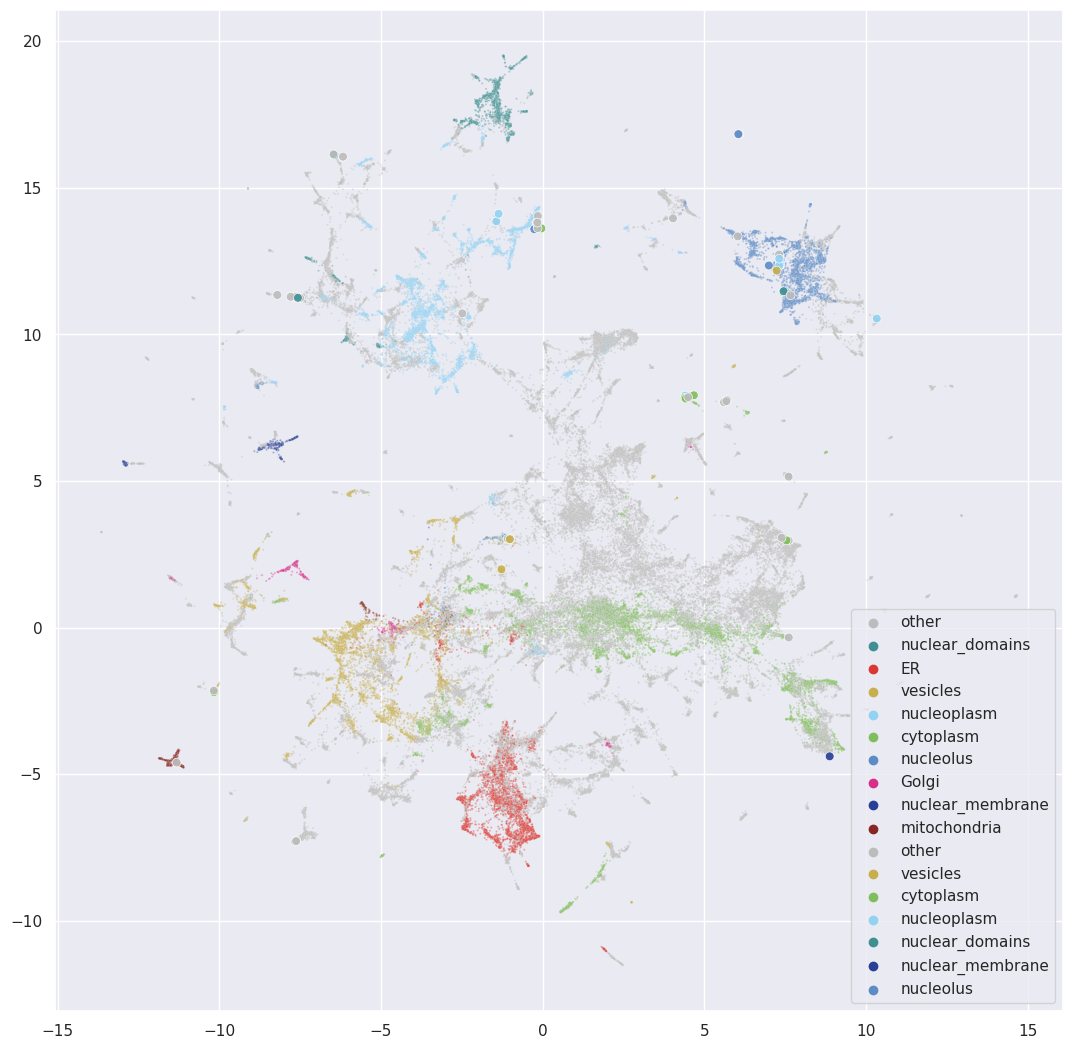

In [17]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

In [18]:
reduced_true_outputs = reducer.transform(true_latents.reshape(true_latents.shape[0], -1))

<AxesSubplot:>

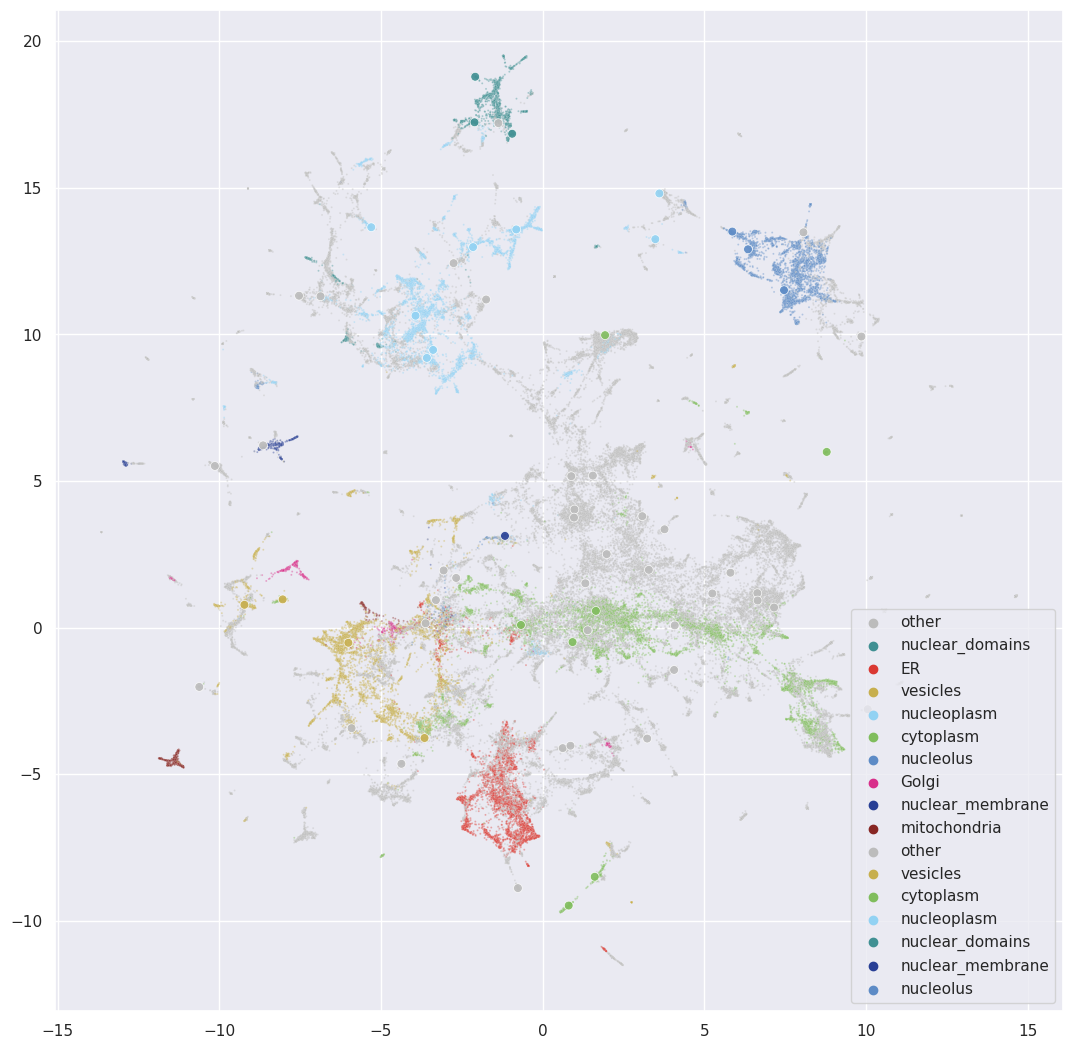

In [19]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_true_outputs[:, 0], y=reduced_true_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

In [23]:
np.abs(true_latents).mean()

0.64382553

In [24]:
((true_latents - predicted_latents)**2).mean()

0.6159926

In [ ]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

In [ ]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=50, alpha=0.9, palette=label_colors)